# **Generated Content Detector Project: AI generated photos vs real photos**
# **Statistical Models**

## **Importing Libraries**

In [1]:
import numpy as np
import cv2
import random
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
import torchvision.datasets as datasets

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.naive_bayes import GaussianNB

## **Defining helper functions**
###### This section defines a series of helper functions that facilitate the extraction and analysis of features from grayscale images. These functions perform specific tasks, such as calculating Fourier features, gradient statistics, local contrast measures, and more. By modularizing these operations, the code enhances readability and reusability, allowing for efficient processing and analysis in subsequent stages of the project.

#### **Radial Power Profile Calculation**
###### Calculates normalized radial averages of the log magnitude spectrum, enabling insights into frequency distribution across images.

In [2]:
def radial_power_profile(log_mag, n_bins=32):
    """
    Compute radial average of log magnitude spectrum.
    Returns a vector of length n_bins.
    """
    h, w = log_mag.shape
    cy, cx = h // 2, w // 2

    y, x = np.indices((h, w))
    r = np.sqrt((x - cx) ** 2 + (y - cy) ** 2)

    r_norm = r / (r.max() + 1e-8)
    r_bin = np.minimum((r_norm * (n_bins - 1)).astype(np.int32), n_bins - 1)

    radial_sum = np.bincount(r_bin.ravel(), weights=log_mag.ravel(), minlength=n_bins)
    radial_count = np.bincount(r_bin.ravel(), minlength=n_bins)

    radial_mean = radial_sum / (radial_count + 1e-8)
    return radial_mean

#### **Fourier Transform and Feature Generation**
###### Extracts a list of features derived from the 2D Fourier transform, providing insights into frequency distribution through logarithmic and radial profiles.

In [3]:
def fourier_features(gray_img, n_bins=32):
    """
    gray_img: float32 array in range [0,1]
    Returns list of Fourier based features.
    """
    # two dimensional FFT
    f = np.fft.fft2(gray_img)
    fshift = np.fft.fftshift(f)
    mag = np.abs(fshift)
    log_mag = np.log1p(mag)  # log(1 + |F|)

    # radial profile of log magnitude
    radial = radial_power_profile(log_mag, n_bins=n_bins)

    # fit line to log power vs log frequency (skip first bin)
    freqs = np.linspace(1e-3, 1.0, n_bins)
    x = np.log(freqs[1:])
    y = radial[1:]
    slope, intercept = np.polyfit(x, y, 1)

    # predicted and deviation
    y_pred = slope * x + intercept
    dev = y - y_pred
    max_dev = np.max(dev)
    min_dev = np.min(dev)
    idx_max_dev = np.argmax(dev) / len(dev)
    idx_min_dev = np.argmin(dev) / len(dev)

    # band powers and ratios
    third = n_bins // 3
    low_band = radial[:third].mean()
    mid_band = radial[third:2*third].mean()
    high_band = radial[2*third:].mean()

    low_mid_ratio = low_band / (mid_band + 1e-8)
    low_high_ratio = low_band / (high_band + 1e-8)
    mid_high_ratio = mid_band / (high_band + 1e-8)

    feats = [
        slope,
        intercept,
        max_dev,
        min_dev,
        idx_max_dev,
        idx_min_dev,
        low_band,
        mid_band,
        high_band,
        low_mid_ratio,
        low_high_ratio,
        mid_high_ratio,
    ]

    # also include the radial curve itself (limited) as features
    feats.extend(radial.tolist())
    return feats

#### **Gradient Magnitude Analysis with Statistical Moments**
###### Extracts gradient statistics, including mean, standard deviation, skewness, and kurtosis, to characterize the edge content of a grayscale image.

In [4]:
def gradient_stats(gray_img):
    """
    Sobel gradient magnitude statistics.
    """
    gx = cv2.Sobel(gray_img, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray_img, cv2.CV_32F, 0, 1, ksize=3)
    mag = np.sqrt(gx ** 2 + gy ** 2).ravel()

    # small epsilon to avoid division by zero
    eps = 1e-8
    mean = np.mean(mag)
    std = np.std(mag) + eps
    centered = mag - mean
    skew = np.mean((centered / std) ** 3)
    kurt = np.mean((centered / std) ** 4) - 3.0

    return [mean, std, skew, kurt]

#### **Local Contrast Analysis via Blurred Moments**
###### Calculates key statistics for local variance using a blurring technique, aiding in the evaluation of local texture and contrast in grayscale images.

In [5]:
def local_contrast_stats(gray_img, window_size=7):

    # ensure float32
    img = gray_img.astype(np.float32)

    k = (window_size, window_size)
    mean_local = cv2.blur(img, k)
    mean_sq_local = cv2.blur(img * img, k)
    var_local = np.clip(mean_sq_local - mean_local ** 2, 0.0, None)

    vals = var_local.ravel()
    mean_var = np.mean(vals)
    std_var = np.std(vals)
    p25 = np.percentile(vals, 25)
    p50 = np.percentile(vals, 50)
    p75 = np.percentile(vals, 75)

    return [mean_var, std_var, p25, p50, p75]

#### **Residual after Gaussian blur and its statistics**
###### Calculates noise statistics and power from the residuals after Gaussian blurring, aiding in the evaluation of noise levels in images.

In [6]:
def residual_noise_stats(gray_img, blur_ksize=3):

    img = gray_img.astype(np.float32)
    blurred = cv2.GaussianBlur(img, (blur_ksize, blur_ksize), 0)
    residual = img - blurred
    vals = residual.ravel()

    eps = 1e-8
    mean = np.mean(vals)
    std = np.std(vals) + eps
    centered = vals - mean
    skew = np.mean((centered / std) ** 3)
    kurt = np.mean((centered / std) ** 4) - 3.0

    # power of residual
    power = np.mean(residual ** 2)

    return [mean, std, skew, kurt, power]

#### **Global Brightness and Contrast Analysis**
###### Computes global statistics of brightness and contrast, enabling the evaluation of overall image intensity distribution and pixel value characteristics.

In [7]:
def global_intensity_stats(gray_img):

    vals = gray_img.ravel()
    mean = np.mean(vals)
    std = np.std(vals)
    p1 = np.percentile(vals, 1)
    p5 = np.percentile(vals, 5)
    p95 = np.percentile(vals, 95)
    p99 = np.percentile(vals, 99)

    frac_dark = np.mean(vals < 0.05)
    frac_bright = np.mean(vals > 0.95)

    return [mean, std, p1, p5, p95, p99, frac_dark, frac_bright]

#### **Feature Vector Generation from Grayscale Image**
###### Defines a method to extract and compile diverse features from a grayscale image, enabling enhanced image analysis and classification.

In [8]:
def extract_all_features_from_gray(gray_img):
    """
    gray_img is a float32 array in range [0,1]
    Returns a single feature vector as numpy array.
    """
    feats = []

    feats.extend(fourier_features(gray_img, n_bins=32))
    feats.extend(gradient_stats(gray_img))
    feats.extend(local_contrast_stats(gray_img, window_size=7))
    feats.extend(residual_noise_stats(gray_img, blur_ksize=3))
    feats.extend(global_intensity_stats(gray_img))

    return np.array(feats, dtype=np.float32)

#### **Retrieve and Resize Grayscale Image**
###### Extracts an image from the dataset at a given index, converting it to grayscale and resizing it to a uniform size for analysis.

In [9]:
def load_gray_image_from_dataset(dataset, idx, size=256):
    """
    Open image from dataset by index, convert to gray and resize.
    """
    path, _ = dataset.samples[idx]
    img = Image.open(path).convert("L")
    img = img.resize((size, size))
    arr = np.array(img).astype(np.float32) / 255.0
    return arr

#### **Feature Matrix Construction**
###### Creates a comprehensive feature matrix and label vector by iterating through specified image indices, facilitating training and evaluation.

In [10]:
def build_feature_matrix(dataset, indices, size=256):
    """
    Build feature matrix X and label vector y for given indices.
    """
    X_list = []
    y_list = []

    for idx in tqdm(indices, desc="Extracting features"):
        gray = load_gray_image_from_dataset(dataset, idx, size=size)
        feats = extract_all_features_from_gray(gray)
        X_list.append(feats)
        y_list.append(dataset.targets[idx])

    X = np.vstack(X_list)
    y = np.array(y_list, dtype=np.int64)
    return X, y

## **Downloading the dataset**

In [11]:
!gdown 1u4xb45DdfP80kxJ20DV20qAGyhcDaCDL

Downloading...
From (original): https://drive.google.com/uc?id=1u4xb45DdfP80kxJ20DV20qAGyhcDaCDL
From (redirected): https://drive.google.com/uc?id=1u4xb45DdfP80kxJ20DV20qAGyhcDaCDL&confirm=t&uuid=256b2e1d-4ed5-4368-a143-eb3815ea241e
To: /content/AI-face-detection-Dataset-v3.zip
100% 1.12G/1.12G [00:11<00:00, 101MB/s]


In [ ]:
!unzip /content/AI-face-detection-Dataset-v3.zip

## **Data Splitting: Train, Val, Test Sets**

In [13]:
dataset = datasets.ImageFolder("/content/AI-face-detection-Dataset-v3/")
dataset

Dataset ImageFolder
    Number of datapoints: 9996
    Root location: /content/AI-face-detection-Dataset-v3/

In [14]:
# Split by class (real + ai separately)
indices_real = [i for i, (_, label) in enumerate(dataset) if label == dataset.class_to_idx["real_color"]]
indices_ai   = [i for i, (_, label) in enumerate(dataset) if label == dataset.class_to_idx["AI"]]

# Train size 70%, Validation size 10%, Test size 20%
def split_class(indices, train_ratio=0.7, val_ratio=0.1):
    train_len = int(len(indices) * train_ratio)
    val_len = int(len(indices) * val_ratio)
    return indices[:train_len], indices[train_len:train_len + val_len], indices[train_len + val_len:]

train_real, val_real, test_real = split_class(indices_real)
train_ai, val_ai, test_ai = split_class(indices_ai)

# Combine training, validation, and testing indices
train_indices = train_real + train_ai
val_indices = val_real + val_ai
test_indices = test_real + test_ai

classes = dataset.classes

## **Extracting statistical features and building the feature matrix**
###### Building feature matrices and label vectors for training, validation, and testing subsets using a fixed image size of 256 pixels. Displaying the shapes of the resulting matrices.

In [15]:
# choose a fixed size for statistics
IMG_SIZE = 256

print("Building train feature matrix")
X_train, y_train = build_feature_matrix(dataset, train_indices, size=IMG_SIZE)

print("Building validation feature matrix")
X_val, y_val = build_feature_matrix(dataset, val_indices, size=IMG_SIZE)

print("Building test feature matrix")
X_test, y_test = build_feature_matrix(dataset, test_indices, size=IMG_SIZE)

print("Feature shape:", X_train.shape)

Building train feature matrix


Extracting features: 100%|██████████| 6996/6996 [03:20<00:00, 34.94it/s]


Building validation feature matrix


Extracting features: 100%|██████████| 998/998 [00:29<00:00, 33.75it/s]


Building test feature matrix


Extracting features: 100%|██████████| 2002/2002 [01:11<00:00, 27.98it/s]

Feature shape: (6996, 66)


## **Defining Classifiers**
###### Defining a set of candidate machine learning models for classification, including Logistic Regression, Ridge Classifier, Support Vector Classifiers, K-Nearest Neighbors, Decision Tree, Random Forest, Extra Trees, Gradient Boosting, and Gaussian Naive Bayes. Each model is configured with specific parameters to optimize performance during training.

In [16]:
candidate_models = {
    "LogisticRegression": LogisticRegression(max_iter=2000), # Logistic regression model with a maximum of 2000 iterations
    "RidgeClassifier": RidgeClassifier(), # Ridge classifier for linear classification with L2 regularization
    "LinearSVC": LinearSVC(), # Linear Support Vector Classifier for binary classification
    "SVC_rbf": SVC(kernel="rbf"), # Support Vector Classifier with RBF kernel for non-linear classification
    "KNN_5": KNeighborsClassifier(n_neighbors=5), # K-Nearest Neighbors classifier with 5 neighbors
    "DecisionTree": DecisionTreeClassifier(), # Decision tree classifier for flexible decision-making
    "RandomForest_300": RandomForestClassifier(  # Random forest classifier with 300 trees
        n_estimators=300,
        n_jobs=-1,
        class_weight="balanced_subsample", # Balance class weights based on subsample for each tree
        random_state=42, # Seed for reproducibility
    ),
    "ExtraTrees_300": ExtraTreesClassifier(  # Extremely Randomized Trees classifier with 300 trees
        n_estimators=300,
        n_jobs=-1,
        class_weight="balanced_subsample", # Balance class weights based on subsample for each tree
        random_state=42,  # Seed for reproducibility
    ),
    "GradBoost": GradientBoostingClassifier(random_state=42), # Gradient boosting classifier with a seed for reproducibility
    "HistGradBoost": HistGradientBoostingClassifier(random_state=42), # Histogram-based gradient boosting classifier with a seed
    "GaussianNB": GaussianNB(), # Gaussian Naive Bayes classifier for probabilistic classification
}

## **Training the candidate models**

In [17]:
rows = []

for name, model in candidate_models.items():
    try:
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)

        acc = accuracy_score(y_val, y_val_pred)
        f1_macro = f1_score(y_val, y_val_pred, average="macro")

        rows.append(
            {
                "model": name,
                "val_accuracy": acc,
                "val_f1_macro": f1_macro,
            }
        )
    except Exception as e:
        rows.append(
            {
                "model": name,
                "val_accuracy": np.nan,
                "val_f1_macro": np.nan,
            }
        )
        print(f"Model {name} failed with error: {e}")

results_df = pd.DataFrame(rows)
results_df = results_df.sort_values(
    by=["val_accuracy", "val_f1_macro"],
    ascending=False,
).reset_index(drop=True)

print(results_df)

                 model  val_accuracy  val_f1_macro
0            GradBoost      0.843687      0.843082
1        HistGradBoost      0.829659      0.828612
2     RandomForest_300      0.811623      0.809864
3            LinearSVC      0.779559      0.778406
4       ExtraTrees_300      0.751503      0.745602
5      RidgeClassifier      0.746493      0.743082
6         DecisionTree      0.745491      0.745159
7   LogisticRegression      0.742485      0.739490
8           GaussianNB      0.677355      0.673949
9                KNN_5      0.628257      0.619781
10             SVC_rbf      0.532064      0.489233


## **Choosing the best model and evaluating performance on the test set**

#### Checking for overfitting

In [18]:
best_name = "GradBoost"
best_model = candidate_models[best_name]

best_model.fit(X_train, y_train)

y_test_pred = best_model.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print("Test classification report:")
print(classification_report(y_test, y_test_pred, target_names=classes))

print("Test confusion matrix:")
print(confusion_matrix(y_test, y_test_pred))

Test accuracy: 0.8551448551448552
Test classification report:
              precision    recall  f1-score   support

          AI       0.89      0.81      0.85      1001
  real_color       0.82      0.90      0.86      1001

    accuracy                           0.86      2002
   macro avg       0.86      0.86      0.85      2002
weighted avg       0.86      0.86      0.85      2002

Test confusion matrix:
[[807 194]
 [ 96 905]]


#### Testing on full dataset

In [19]:
best_name = "GradBoost"
best_model = candidate_models[best_name]

X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

best_model.fit(X_train_full, y_train_full)


y_test_pred = best_model.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print("Test classification report:")
print(classification_report(y_test, y_test_pred, target_names=classes))

print("Test confusion matrix:")
print(confusion_matrix(y_test, y_test_pred))

Test accuracy: 0.8801198801198801
Test classification report:
              precision    recall  f1-score   support

          AI       0.90      0.85      0.88      1001
  real_color       0.86      0.91      0.88      1001

    accuracy                           0.88      2002
   macro avg       0.88      0.88      0.88      2002
weighted avg       0.88      0.88      0.88      2002

Test confusion matrix:
[[854 147]
 [ 93 908]]


###### **Assessing GradBoost Performance:** The analysis evaluates the "GradBoost" model for potential overfitting, achieving an accuracy of 88.01% on the test set. The classification report shows a precision of 0.90 and recall of 0.85 for the 'AI' category, and a precision of 0.86 with a recall of 0.91 for 'real_color,' resulting in balanced F1-scores of 0.88 for both classes. The confusion matrix reveals 854 true positives for 'AI' and 93 false positives, providing clarity on prediction accuracy. Overall, the model does not exhibit overfitting issues, as the performance metrics on the test set align well with those from the training data, indicating strong generalization.

## **Visualizing the predictions**
###### This section displays random examples from the test set for each class, showcasing the true labels alongside the predicted labels from the best model. By selecting up to ten random images per class, it provides a visual representation of the model's predictions, enabling a clearer understanding of classification performance and areas for improvement.



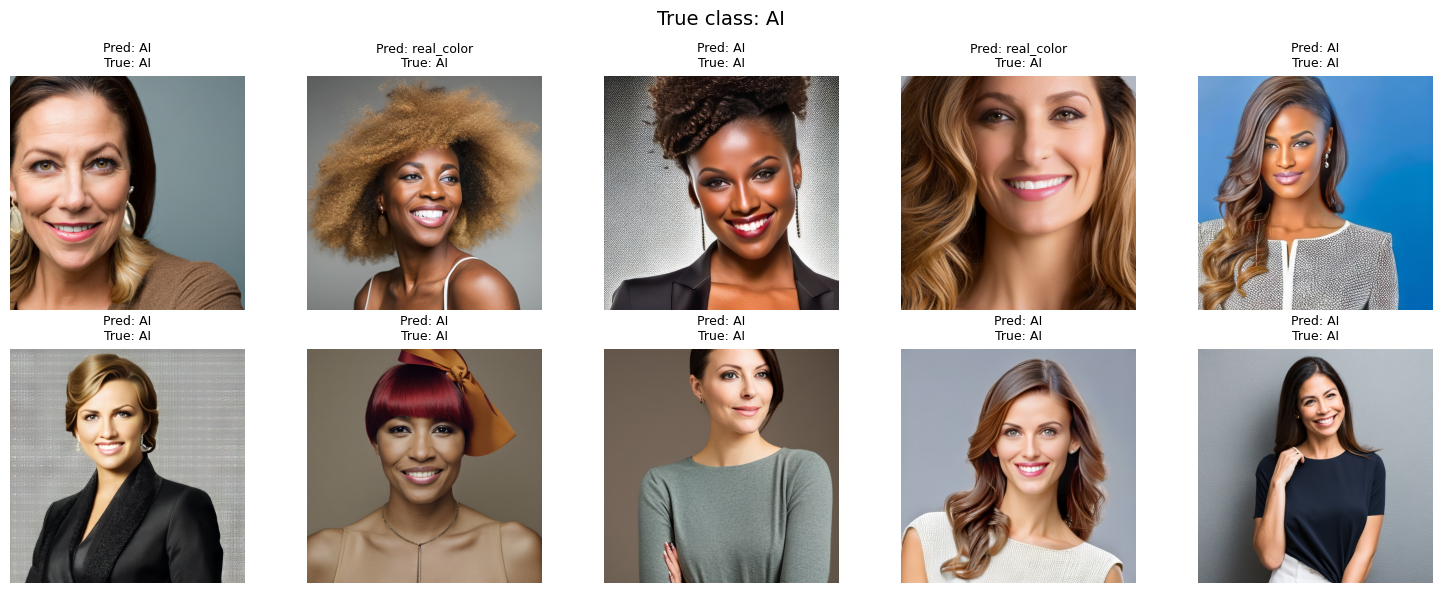

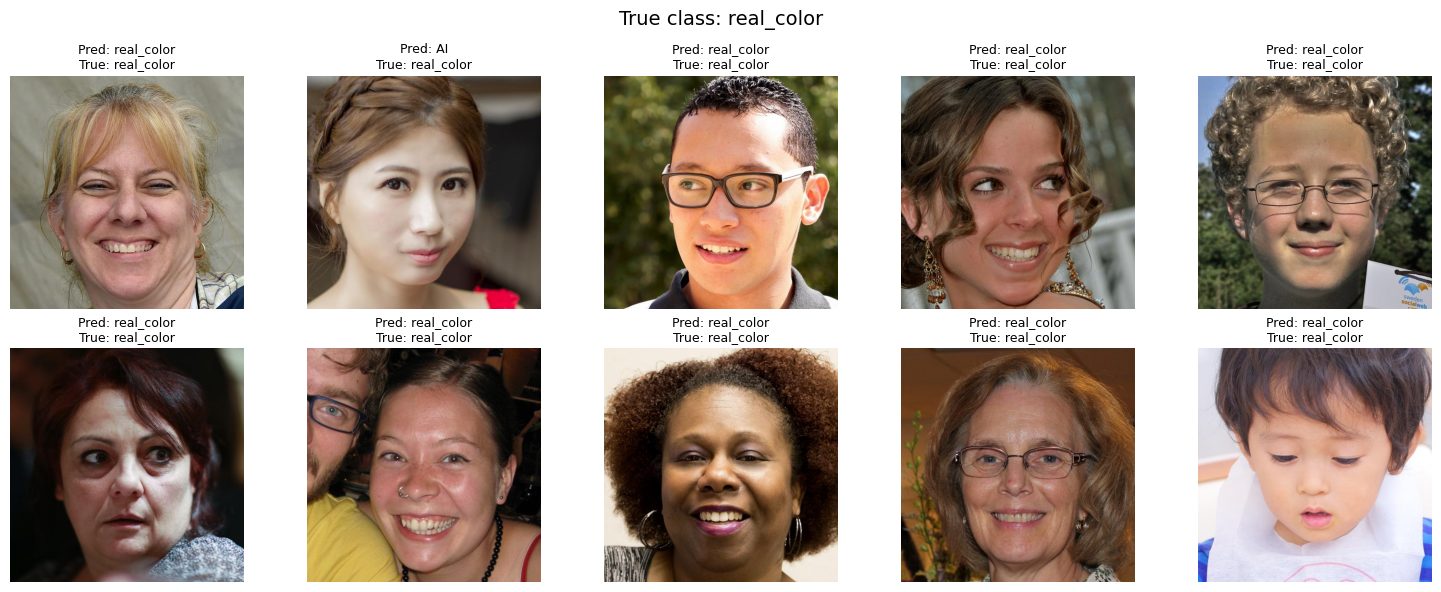

In [20]:
# get predictions on test features
y_test_pred = best_model.predict(X_test)

def show_random_examples_per_class(n_per_class=10):
    for class_idx, class_name in enumerate(classes):
        # indices in the test split that belong to this true class
        test_pos = [i for i, label in enumerate(y_test) if label == class_idx]
        if len(test_pos) == 0:
            print(f"No samples for class {class_name} in test set")
            continue

        # choose up to n_per_class random indices
        chosen = random.sample(test_pos, min(n_per_class, len(test_pos)))

        cols = 5
        rows = int(np.ceil(len(chosen) / cols))

        plt.figure(figsize=(3 * cols, 3 * rows))
        plt.suptitle(f"True class: {class_name}", fontsize=14)

        for j, idx in enumerate(chosen):
            ds_idx = test_indices[idx]          # index into original dataset
            img_path, _ = dataset.samples[ds_idx]

            img = Image.open(img_path).convert("RGB")

            ax = plt.subplot(rows, cols, j + 1)
            ax.imshow(img)
            ax.axis("off")

            true_label = classes[y_test[idx]]
            pred_label = classes[y_test_pred[idx]]
            ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=9)

        plt.tight_layout()
        plt.show()

# call this to see ten random examples per class
show_random_examples_per_class(n_per_class=10)